# Week 5 Assignment

## Summary:

In this week's assignment, I used the glob library to load in 16 files - each containing tweets from various news media sources, with the full dataset totaling to over 65,000 tweets. The `cleanCorpus` function was modified so that the `spaCy` library would do most of the text processing functions that are usually done with the `NLTK` library. In the beginning of the function, only apostrophes are removed from the tweets so that contractions aren't separated when tokenized (e.g. people's -> people and 's) and can be properly lemmatized later. After converting the text to a `spaCy` object, the function checks if the lemmatization of a word is a pronoun (changed from the actual word to `-PRON-`) and if so, keep the normal text of the word so that it can get properly checked in the stopwords section. If the word is not a pronoun, then it keeps its lemmatized form. Next, the words are checked to see if they are stopwords, retweets, URLs, or usernames (**note**: `spaCy` does tweet tokenization, so URLs and usernames stay together with their prefix (`http` and `@`, respectively). Finally, the rest of the punctuation and double spaces (caused by removing dashes between whitespaces) are removed before adding the cleaned tweet to the `clean_document` list.

In [1]:
import numpy as np
import pandas as pd
import string
import spacy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords

from glob import iglob

en_stopwords = stopwords.words('english')  
stopwords = set(en_stopwords)
nlp = spacy.load("en")

%matplotlib inline

In [2]:
#initialize an empty dataframe
#empty dataframe will hold all the tweets from all the files
healthtweet_df = pd.DataFrame()

In [3]:
#load in each text file from the Health Tweets folder
for file in iglob('Health-Tweets/*.txt'):
    
    #each file read in as dataframe
    df = pd.read_csv(file,
                     sep='|',
                     header=None,
                     error_bad_lines=False,
                     encoding='latin-1')
    
    #single file dataframe is attached to larger dataframe
    healthtweet_df = healthtweet_df.append(df, ignore_index=True)

b'Skipping line 846: expected 3 fields, saw 4\nSkipping line 904: expected 3 fields, saw 4\nSkipping line 914: expected 3 fields, saw 4\nSkipping line 1264: expected 3 fields, saw 4\nSkipping line 1269: expected 3 fields, saw 4\nSkipping line 1293: expected 3 fields, saw 4\nSkipping line 1348: expected 3 fields, saw 4\nSkipping line 1430: expected 3 fields, saw 4\nSkipping line 1486: expected 3 fields, saw 4\nSkipping line 1710: expected 3 fields, saw 4\nSkipping line 2699: expected 3 fields, saw 4\nSkipping line 2728: expected 3 fields, saw 4\nSkipping line 3000: expected 3 fields, saw 4\n'
b'Skipping line 1422: expected 3 fields, saw 4\nSkipping line 1461: expected 3 fields, saw 4\nSkipping line 1468: expected 3 fields, saw 4\nSkipping line 1507: expected 3 fields, saw 4\nSkipping line 1547: expected 3 fields, saw 4\nSkipping line 1728: expected 3 fields, saw 4\nSkipping line 1738: expected 3 fields, saw 4\nSkipping line 1742: expected 3 fields, saw 4\nSkipping line 1847: expected 3 

In [4]:
#how many rows (tweets)
len(healthtweet_df)

62817

In [5]:
#add column headers to the dataframe
healthtweet_df.columns = ['ID', 'timestamp', 'tweet']

In [6]:
#verify dataframe contents
healthtweet_df.head(10)

,ID,timestamp,tweet
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised http://bbc.in/...
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll http://bbc...
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater' http://bbc...
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising' http://bb...
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors http://bb...
5,585733482413891584,Wed Apr 08 09:18:39 +0000 2015,Review of case against NHS manager http://bbc....
6,585733481608646657,Wed Apr 08 09:18:39 +0000 2015,"VIDEO: 'All day is empty, what am I going to d..."
7,585701601131765761,Wed Apr 08 07:11:58 +0000 2015,VIDEO: 'Overhaul needed' for end-of-life care ...
8,585620828110397440,Wed Apr 08 01:51:00 +0000 2015,Care for dying 'needs overhaul' http://bbc.in/...
9,585437294120677376,Tue Apr 07 13:41:42 +0000 2015,VIDEO: NHS: Labour and Tory key policies http:...


In [7]:
#convert "tweet" column into a list
healthtweet_ls = healthtweet_df['tweet'].to_list()

In [8]:
"""
This function will return a list (clean_document) that contains each document (tweet) as a string after making the text lowercase, removing aspotrophes, 
converting into a spaCy object (tokenizing), lemmatizing the words, removing stopwords and Twitter-related extras, rejoining as a string,
then removing all remaining punctuation, numbers, and double white spaces. The final string product is then added to the 'clean_document' list.
"""

#function to lowercase, remove punctuation/digits, tokenize (split into words), and remove stopwords
def cleanCorpus(corpus):
    
    clean_document = []
    
    for doc in corpus:
        """
        stopwords (list) has split contractions in it
        """
        #apostrophes to look for
        #so words like "people's" don't become "people" and "'s"
        table = str.maketrans({key: None for key in "'" + "‘" + "’"})
        
        #string w/o apostrophe                    
        no_apos_str = doc.translate(table).lower()
        
        #make tweet into a spaCy object
        nlpdoc = nlp(no_apos_str)
        
        #holds words that are lemmatized, with tweet stuff (http, URLs, and @user) removed
        clean_lemmals = []
        
        
        for token in nlpdoc:
            
            #check to see if lemma is "-PRON-"
            #needs to stay in normal text form to get checked as a stopword
            if token.lemma_ == '-PRON-':
                token_lem = token.text
            else:
            #lemmatize the word
                token_lem = token.lemma_
            
            #check for stopwords, retweets ("RT"), URLs, or users (@username)
            if (token_lem in stopwords) or (token_lem == "rt") or (token_lem.startswith(("http",'@'))): pass
            
            else: clean_lemmals.append(token_lem)
                
        
        #join list of cleaned words together into one string
        clean_str = " ".join(clean_lemmals)  

        #remove rest of punctuation and digits
        #didn't do earlier b/c I didn't want @ removed
        table = str.maketrans({key: None for key in string.punctuation + string.digits + "¦"})
        nopunct_digits = clean_str.translate(table)
        rmv_ws = nopunct_digits.replace("  ", " ")
    
        #add string of the cleaned tweet to this list
        clean_document.append(rmv_ws)
        

    #confirmation that all documents are finished with text cleaning process
    print("Corpus is clean.")
    
    #returned output is a list with each document item from corpus as a string
    return clean_document

In [9]:
#run the cleanCorpus function
cleanhealth_ls = cleanCorpus(healthtweet_ls)

Corpus is clean.


### TF-IDF

After running the `cleanCorpus` function on the dataset, I used the `TfidfVectorizer()` function to convert the cleaned tweet data into a matrix, where each row is a tweet and the columns are the terms from all the tweets. The total number of terms in the matrix is 22,254 words.

In [10]:
#save TF-IDF vectorizer into a variable
tfidfvec = TfidfVectorizer()

In [11]:
#make a TF-IDF matrix from the text data
twt_mtx = tfidfvec.fit_transform(cleanhealth_ls)

In [12]:
#dimensions of the matrix
twt_mtx.shape

(62817, 22259)

### KMeans

Using the K-Means function with 10 clusters initialized and randomized data, I fit the data into the model and used the `predict` function to produce the cluster assignment for each tweet. Then using the `silhouette_score` function in combination with the TF-IDF matrix and cluster prediction assignments, I calculated the silhouette score for the 10 cluster K-Means model.

In [13]:
#save the KMeans algorithm into a variable
#initialized with 10 clusters and randomize the data
kmeans10 = KMeans(n_clusters=10, random_state=10)

In [14]:
#build the model with the data
kmeans10.fit(twt_mtx)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)

In [15]:
#predict which clusters the tweets belong to
cluster_pred = kmeans10.predict(twt_mtx)

In [16]:
#verify first 5 data points' cluster assignments
cluster_pred[:5]

array([0, 0, 0, 1, 0])

In [17]:
#get the silhouette score for the model    
sil_avg = silhouette_score(twt_mtx, cluster_pred)

print(f"For 10 clusters, the average silhouette score is: {sil_avg}")

For 10 clusters, the average silhouette score is: 0.007501837023813563


### Top Terms

First, I (separatedly) gathered the tweets that were assigned to Cluster 0 & 3, and then used the `FreqDist` and `.most_common()` functions to get the top 10 words in those clusters. After verifying the results, I ran a loop to get the top 5 words for each cluster in the K-Means model assignment output.

In [18]:
#get the tweets that were assigned to Cluster 0
#verify the first 5 tweets in the cluster
c0twt = np.array(cleanhealth_ls)[cluster_pred == 0]
c0twt[:5]

array(['breast cancer risk test devise', 'gp workload harm care bma poll',
       'short people heart risk great', 'coalition undermine nhs doctor',
       'review case nhs manager'], dtype='<U9509')

In [19]:
#create a frequency distribution of the tweets in Cluster 0
#get top 10 words in Cluster 0
wordcount = FreqDist(word_tokenize(' '.join(c0twt)))
wordcount.most_common(10)
#us is U.S. (periods were removed after stopword cleanup)

[('cancer', 1529),
 ('us', 1468),
 ('drug', 1324),
 ('nhs', 1227),
 ('food', 1204),
 ('help', 1048),
 ('patient', 1024),
 ('good', 990),
 ('doctor', 978),
 ('hospital', 914)]

In [20]:
#get the tweets that were assigned to Cluster 3
#verify the first 5 tweets in the cluster
c3twt = np.array(cleanhealth_ls)[cluster_pred == 3]
c3twt[:5]

array(['treat nhs whistleblower well mps', ' needle well one',
       'well sex  dementia care call',
       'well hospital food may become law',
       'british ebola patient pretty well'], dtype='<U9509')

In [21]:
#create a frequency distribution of the tweets in Cluster 3
#get top 10 words in Cluster 3
wordcount3 = FreqDist(word_tokenize(' '.join(c3twt)))
wordcount3.most_common(10)

[('well', 2006),
 ('may', 130),
 ('doctor', 119),
 ('health', 113),
 ('cancer', 113),
 ('ask', 112),
 ('exercise', 84),
 ('get', 83),
 ('patient', 74),
 ('risk', 74)]

In [22]:
#print the top 5 words for each cluster from the KMeans model (10 clusters)

k10cluster_labels = list(set(cluster_pred))

for cluster_label in k10cluster_labels:
    
    cluster_tweets = np.array(cleanhealth_ls)[cluster_pred == cluster_label]
    
    top5 = FreqDist(word_tokenize(' '.join(cluster_tweets))).most_common(5)
    
    print(f"The Top 5 words in Cluster {cluster_label}:")
    
    for word in top5:
        print(word[0])
        
    print("\n")

The Top 5 words in Cluster 0:
cancer
us
drug
nhs
food


The Top 5 words in Cluster 1:
new
old
age
blog
york


The Top 5 words in Cluster 2:
health
law
care
insurance
mental


The Top 5 words in Cluster 3:
well
may
doctor
health
cancer


The Top 5 words in Cluster 4:
get
health
way
help
new


The Top 5 words in Cluster 5:
make
weight
lose
loss
help


The Top 5 words in Cluster 6:
say
study
ebola
health
us


The Top 5 words in Cluster 7:
may
help
risk
study
cancer


The Top 5 words in Cluster 8:
study
find
cancer
risk
drug


The Top 5 words in Cluster 9:
ebola
us
patient
outbreak
africa




### Optimal Clusters

Based on the silhouette score for the 10 cluster K-Means model, I looped through a list of numbers to represent 15-20 clusters and produce a silhouette score for each. Then using that same list of numbers, I also calculated the WSS score and plotted it as an Elbow Curve to see the trend of possible optimal clusters for this dataset.

In [23]:
#create a list of numbers 15-20
#will use to evaluate the model with 15-20 clusters
cluster_num = list(range(15,21))

In [24]:
#silhouette score of 15-20 clusters

for n in cluster_num:
    
    kmeans = KMeans(n_clusters=n, random_state=10)
    
    cluster_pred = kmeans.fit_predict(twt_mtx)
    
    sil_avg = silhouette_score(twt_mtx, cluster_pred)
    
    print(f"For {n} clusters, the average silhouette score is: {sil_avg}")

For 15 clusters, the average silhouette score is: 0.008654045571451968
For 16 clusters, the average silhouette score is: 0.008768678766837495
For 17 clusters, the average silhouette score is: 0.009404388516385625
For 18 clusters, the average silhouette score is: 0.010466856753471334
For 19 clusters, the average silhouette score is: 0.009476304442323698
For 20 clusters, the average silhouette score is: 0.010888852443090374


In [25]:
#calculate WSS for 15-20 clusters
scores = []

for n in cluster_num:
    
    kmeans = KMeans(n_clusters=n, random_state=10)
    
    score = kmeans.fit(twt_mtx).score(twt_mtx)
    scores.append(score)

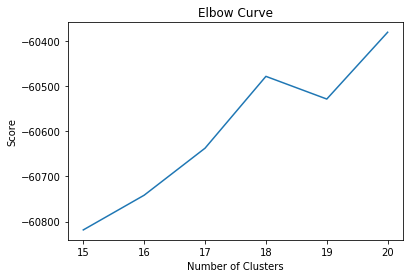

In [26]:
#plot Elbow Curve for 15-20 clusters
plt.plot(cluster_num,scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Elbow Curve")
plt.show()

In [27]:
#WSS scores
scores

[-60818.588940819485,
 -60741.66522618543,
 -60637.4822595683,
 -60478.31723401694,
 -60528.59707546889,
 -60380.56102542885]

## Conclusion:

About half of the time for this assignment was spent modifiying the `cleanCorpus` function because stopwords were bypassing the checkpoint (in an earlier version of the function, words were checked as stopwords first then lemmatized but some words didn't become stopwords until after the lemmatization). The other majority was used running the model and seeing in the Top 10 list that some stopwords had slipped through. The reason why running the model took more time is because the matrix was computationally expensive and although I attempted to use the `ProcessPoolExecutor()` function, it seems that on my Windows 10 machine I have to add extra functions in a separate script, so I decided to take the time to wait for my computer to finish running the `cleanCorpus` and `.fit()` functions on the data each time I made an adjustment (an estimated 9-11 minutes for each function).

However, once I received an acceptable output from the model, calculating the scores was much easier. The silhouette score for the 10 cluster model was not that great (~0.008) and in a test version of the silhouette score of lower numbered clusters (2-7 clusters), I found the scores getting worse and determined that higher scores might trend towards the optimal number of clusters for this dataset. After running the silhouette score for 15-20 clusters, the results showed that by 20 clusters (~0.011 score) the score seemed to be improving, and therefore more clusters would most likely be best for this model. So I also tested this with WSS scores and by looking at the plot for the same number of clusters (15-20), there is an upward trend that supports my earlier findings for more clusters being suited for this dataset. 

The high number of clusters being optimal for this data is probably due to the number of significant news events that are contained in the dataset. Looking at the common words in Cluster 0, the topic seems to be about the FDA discovering a new drug related to breast cancer. Cluster 3 has words related to a new law involving insurance and mental health. Cluster 8 discusses a case of ebola in a patient in the United States, while Cluster 9 has words regarding the new healthcare related to the National Health Service (in the United Kingdom). With news media outlets reporting big stories on a frequent basis, the number of unique events would most likely surpass 20 topics and would need more clusters to accurately bin them.

## References:

Karami, A. (2018, February 19). Retrieved from https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter. Irvine, CA: University of California, School of Information and Computer Science.

Selecting the number of clusters with silhouette analysis on KMeans clustering. Retrieved from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

K-Means Clustering: Analysing City of London Traffic. Retrieved from https://www.michael-grogan.com/k-means-clustering-python-sklearn/